In [1]:
import cv2
import csv
import numpy as np

In [2]:

def read_points_from_csv(file_path):
    points1 = []
    points2 = []

    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        next(reader)

        for row in reader:

            x1, y1, x2, y2, _ = map(float, row)
            
            points1.append([x1, y1])  
            points2.append([x2, y2])

    return np.array(points1, dtype=np.float32), np.array(points2, dtype=np.float32)


csv_file = 'img2_pair.csv'
right_points1, left_points2 = read_points_from_csv(csv_file)

print("Точки:\n", right_points1[0])

Точки:
 [1160.  570.]


In [3]:
BOARD_SIZE = (7,7)
SQUARE_SIZE = 9.6
objpoints = np.zeros((BOARD_SIZE[0]*BOARD_SIZE[1], 3), np.float32)
objpoints[:,:2] = np.mgrid[0:BOARD_SIZE[0], 0:BOARD_SIZE[1]].T.reshape(-1,2)
objpoints *= SQUARE_SIZE

In [4]:
img_left = cv2.imread('../data/calibrate/imgs/leftcamera/Cam2_2.jpg',cv2.COLOR_BGR2GRAY)
img_right = cv2.imread('../data/calibrate/imgs/rightcamera/Cam1_2.jpg',cv2.COLOR_BGR2GRAY)

height, width = img_right.shape[:2]

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 0.001) 

right_points1 = cv2.cornerSubPix(img_right, right_points1, (4,4), (-1,-1), criteria)
left_points2 = cv2.cornerSubPix(img_left, left_points2, (4,4), (-1,-1), criteria)


H, _ = cv2.findHomography(left_points2, right_points1)

ret1, mtx1, dist1, rvecs1, tvecs1 = cv2.calibrateCamera([objpoints], [left_points2], img_left.shape[::-1], None,None, flags=0)
ret2, mtx2, dist2, rvecs2, tvecs2 = cv2.calibrateCamera([objpoints], [right_points1], img_right.shape[::-1], None,None, flags=0)

newmtx_left, roi_left = cv2.getOptimalNewCameraMatrix(mtx1,dist1,(width,height),1,(width,height))
newmtx_right, roi_rigth = cv2.getOptimalNewCameraMatrix(mtx2,dist2,(width,height),1,(width,height))

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 1000, 1e-5)
flags = 0
flags |= cv2.CALIB_FIX_INTRINSIC

ret, _, _, _, _, R, T, E, F = cv2.stereoCalibrate([objpoints], [left_points2], [right_points1], mtx1, dist1, mtx2, dist2, img_left.shape[::-1], criteria=criteria, flags=flags)

print("Результат калибровки:")
print(f"error left: {ret1}")
print(f"error right: {ret2}")
print(f"error stereo: {ret}")
print(f"H: {H}")
print(f"R: {R}")
print(f"T: {T}")
print(f"Intrinsic left: {mtx1}")
print(f"Intrinsic right: {mtx2}")
print(f"T vec left: {tvecs1}")
print(f"T vec right: {tvecs2}")

Результат калибровки:
error left: 4.336694880310999
error right: 4.647360064017441
error stereo: 4.4947113457926156
H: [[ 9.18905504e-01 -3.72904352e-01  8.67177820e+02]
 [ 5.07769716e-02  8.61656907e-01 -7.10459019e+01]
 [-3.07451058e-05  5.73756894e-06  1.00000000e+00]]
R: [[ 0.83936606 -0.11131758  0.53204606]
 [ 0.10452238  0.99359301  0.04298844]
 [-0.53342262  0.01952768  0.84562343]]
T: [[-246.29611973]
 [ -49.20520582]
 [ 175.3389669 ]]
Intrinsic left: [[2.00967174e+04 0.00000000e+00 2.56278759e+03]
 [0.00000000e+00 2.12113832e+04 2.01981291e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Intrinsic right: [[2.41004408e+04 0.00000000e+00 2.93376915e+03]
 [0.00000000e+00 2.56263289e+04 3.29688606e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
T vec left: (array([[-43.46703326],
       [-27.39976943],
       [445.47912434]]),)
T vec right: (array([[-42.71533359],
       [-61.82228136],
       [574.69761752]]),)


In [49]:
img_left = cv2.imread('../data/calibrate/imgs/leftcamera/Cam2_2.jpg', cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread('../data/calibrate/imgs/rightcamera/Cam1_2.jpg', cv2.IMREAD_GRAYSCALE)

image_size = img_left.shape[::-1]


R1, R2, P1, P2, Q, _, _ = cv2.stereoRectify(mtx1, dist1, mtx2, dist2, image_size, R, T, alpha=0)

map1x, map1y = cv2.initUndistortRectifyMap(mtx1, dist1, R1, P1, image_size, cv2.CV_32FC1)
map2x, map2y = cv2.initUndistortRectifyMap(mtx2, dist2, R2, P2, image_size, cv2.CV_32FC1)


rectified_left = cv2.remap(img_left, map1x, map1y, cv2.INTER_LINEAR)
rectified_right = cv2.remap(img_right, map2x, map2y, cv2.INTER_LINEAR)

num_disparities = 16 * 1 
block_size = 15  


stereo = cv2.StereoSGBM_create(blockSize=block_size,
                               numDisparities=num_disparities)

disparity_map = stereo.compute(rectified_left, rectified_right).astype(np.float32) / 16.0
disparity_visual = cv2.normalize(disparity_map, None, 0, 255, cv2.NORM_MINMAX)
disparity_visual = np.uint8(disparity_visual)

disparity_visual_resize = cv2.resize(rectified_right,(720,480))
cv2.imshow('Disparity Map', disparity_visual_resize)
cv2.waitKey(0)
cv2.destroyAllWindows()
depth_map = cv2.reprojectImageTo3D(disparity_map, Q)

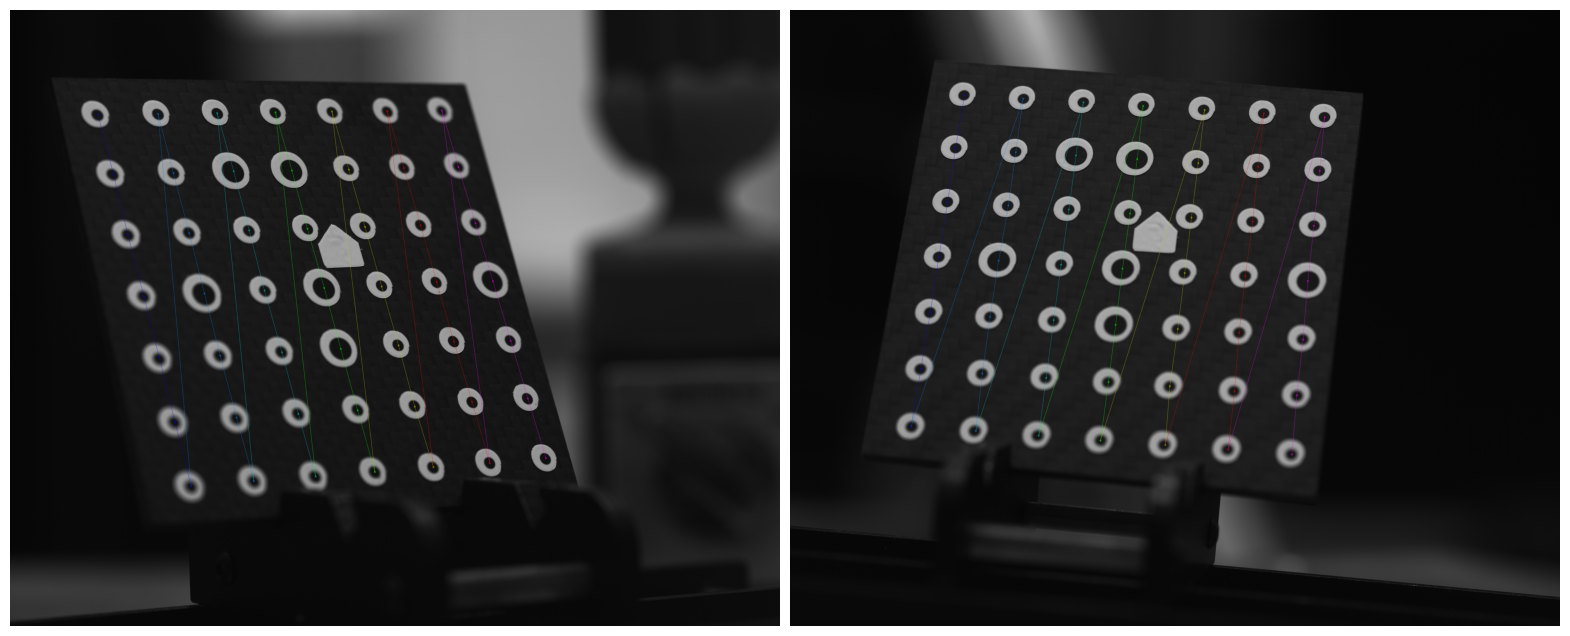

In [5]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
def DisplayImagePoints(path, imgpoints):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.drawChessboardCorners(img, BOARD_SIZE, imgpoints, True)
    return img
    
example_image_left = DisplayImagePoints('../data/calibrate/imgs/leftcamera/Cam2_2.jpg', left_points2)
example_image_right = DisplayImagePoints('../data/calibrate/imgs/rightcamera/Cam1_2.jpg', right_points1)

fig = plt.figure(figsize=(20,20))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 2), axes_pad=0.1)

for ax, im in zip(grid, [example_image_left, example_image_right]):
    ax.imshow(im)
    ax.axis('off')